In [1]:
import torch
import matplotlib.pyplot as plt

import math
from torch.nn.functional import conv1d, softmax
from torch.nn.functional import pad
from torch.autograd import grad

from utils import fft_conv

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = [4, 2]

def polyval(coefs, z):
    eval = coefs[0] + torch.zeros_like(z)
    for c in coefs[1:]:
        eval += eval * z + c
    return eval

## Dissecting Kernels and Frequency Responses

In [2]:
L = M = 100
w = torch.linspace(0, 2 * torch.pi, L)
f = 5
u = torch.sin(f * w * L)

We can inspect the filtering properties of any linear kernel. To do so, 
we plot the amplitude and phase of the frequency response $H(\omega)$ found via an implicit transfer
function parametrization: 

In [3]:
w = torch.linspace(0, 2*torch.pi, 2*L - 1)
z = torch.exp(-1j * w)

# seed
torch.manual_seed(1234)

d = 4
num_poly_coefs = torch.randn(d) # a_0 z^{d-1} + a_1 z^{d-2} + ... + a_{d-1} z + a_d
den_poly_coefs = torch.randn(d)

num = polyval(num_poly_coefs, z)
den = polyval(den_poly_coefs, z)

H = num / den

Text(0, 0.5, 'Phase (rad)')

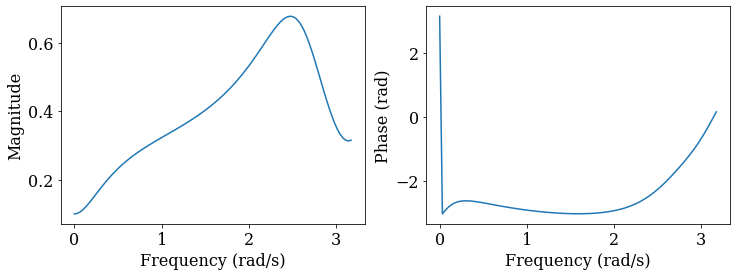

In [4]:
# bode plot 
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# magnitude: this is usually reported in decibels - we use the direct values |H| instead.
# also note how we are selecting the first half of the spectrum, exploiting its 
# conjugate symmetry.
axs[0].plot(w[:L + 1], torch.abs(H[:L + 1]))
axs[0].set_xlabel('Frequency (rad/s)')
axs[0].set_ylabel('Magnitude')

# # phase
axs[1].plot(w[:L + 1], torch.atan2(-H[:L + 1].imag, H[:L + 1].real))
axs[1].set_xlabel('Frequency (rad/s)')
axs[1].set_ylabel('Phase (rad)')

Given a pure sinusoid at a certain frequency $\sin(\omega)$, a linear filter of this type will return a scaled, shifted sinusoid $|H(\omega)| \sin(\omega + \phi)$. 

In [5]:
sols = []

frqs = torch.linspace(1, 45, 6)
for f in frqs:
    w = torch.linspace(0, 2 * torch.pi, L)
    u = torch.sin(f * w)
    u_pad = pad(u, (0, M - 1))

    U = torch.fft.fft(u_pad)
    y = torch.fft.ifft(U * H)[:L]
    sols.append(y)

Text(0.5, 1.0, 'Amplitude $|H(\\omega)|$')

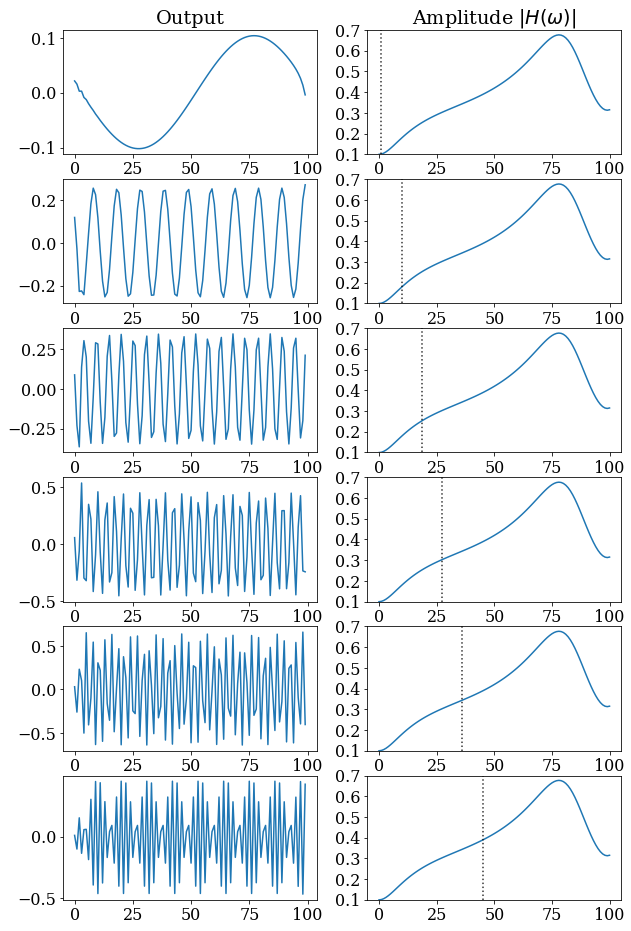

In [6]:
fig, axs = plt.subplots(6, 2, figsize=(10, 16))

for k in range(6): 
    axs[k, 0].plot(sols[k].detach().real)
    axs[k, 1].plot(torch.abs(H[:L + 1]))
    axs[k, 1].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    axs[k, 1].set_ylim(0.1, 0.7)
    axs[k, 1].vlines(frqs[k], 0.1, 0.7, alpha=0.8, color='k', linestyle='dotted')

axs[0, 0].set_title(f'Output')
axs[0, 1].set_title(f'Amplitude $|H(\omega)|$')


Increasing the frequency introduces some numerical artifacts: the output is a "morphed" sinusoid - remember we are
zero padding the input, and as such the sine wave does not extend to infinity as it is assumed by the theoretical result.

Higher order filters are less interpretable. As an example, we provide the amplitude phase plot of the frequency response of an implicit transfer function (order 64) trained on a classification task.

In [8]:
H = torch.load('artifacts/pretrained_frequency_response')
L = H.shape[1]

Text(0, 0.5, 'Phase (rad)')

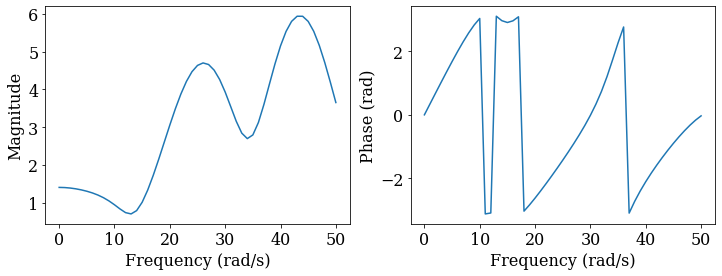

In [9]:
# bode plot
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# magnitude: this is usually reported in decibels - we use |H| instead.
axs[0].plot(torch.abs(H[4, :L//2 + 1]))
axs[0].set_xlabel('Frequency (rad/s)')
axs[0].set_ylabel('Magnitude')

# # phase
axs[1].plot(torch.atan2(-H[4, :L//2 + 1].imag, H[4, :L//2 + 1].real))
axs[1].set_xlabel('Frequency (rad/s)')
axs[1].set_ylabel('Phase (rad)')